In [31]:
%pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\alban\appdata\local\temp\pip-req-build-wk9c1x9d
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Using cached numpy-1.24.2-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\alban\AppData\Local\Temp\pip-req-build-wk9c1x9d'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.2 which is incompatible.
flappy-bird-gym 0.3.0 requires numpy~=1.19.5, but you have numpy 1.24.2 which is incompatible.


**##**Alban Sarfati**##**

In [32]:
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import matplotlib
from pylab import plt, mpl
from collections import defaultdict
import time
import pandas as pd
import os, sys

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(0)

In [33]:
def plot_scores(scores, name):
    x = range(1, len(scores) + 1)
    y = np.polyval(np.polyfit(x, scores, deg=3), x)
    fig = plt.figure(figsize=(12, 7))
    plt.plot(scores, label='scores')
    plt.plot(x, y, 'r--', label='regression scores')
    plt.xlabel('episodes')
    plt.ylabel('scores')
    plt.title(name +f'\n Score: max={np.max(scores)}, mean={int(np.mean(scores))}, std={int(np.std(scores))}')
    plt.legend()
    plt.show()

def plot_value_function(V):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                            cmap=matplotlib.cm.coolwarm)#, vmin=np.min(list(V.values())), vmax=np.max(list(V.values())))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title("Value Function")
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()

In [34]:
class FlappyAgent:
    def __init__(self, env, algo, episodes: int = 1500, alpha: float = 0.7,  alpha_min: float = 0.1,
                 alpha_decay: float = 0.0005, gamma: float = 0.95,
                 epsilon: float = 0.1, epsilon_min: float = 0.01, epsilon_decay: float = 0.0001, neg_reward: int = -1000, plot=True):
        self.env = env
        self.type_algo = algo
        self.episodes = episodes #number of episodes
        self.alpha = alpha #initial learning rate
        self.alpha_min = alpha_min 
        self.alpha_decay = alpha_decay #learning rate decay, 1200 episodes to fully decay
        self.gamma = gamma #discount factor
        self.epsilon = epsilon #chance to explore vs take local optimum
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay # 900 episodes to not explore anymore
        self.neg_reward = neg_reward
        self.plot = plot
        self.Q_values = np.zeros((env.observation_space[0].n, env.observation_space[1].n, env.action_space.n))
        self.V_values = defaultdict(float)
        self.count = defaultdict(float)
        self.scores = []
        self.best_Q_values = self.Q_values.copy()
        self.max_score = 0
        self.name = f'Flappy {algo} Agent\n' + 'alpha='+ str(alpha) + ' alpha_decay=' + str(alpha_decay)+ ' epsilon='+ str(epsilon)\
                    + ' epsilon_decay=' + str(epsilon_decay)+ ' gamma='+str(gamma) + ' neg_reward='+str(neg_reward) + ' episodes='+str(episodes) 

    def _greedy_policy(self, state):
        if np.random.random() <= self.epsilon:
            return self.env.action_space.sample()
        return self._get_action(state)

    def _get_action(self, state):
        return np.argmax(self.Q_values[state])

    def _update_V(self, state, action):
        self.count[state] += 1
        self.V_values[state] = self.Q_values[state][action]/self.count[state]
    
    def _play_one_step(self, state):
        action = self._greedy_policy(state)
        next_state, reward, done, _, info = self.env.step(action)
        return action, next_state, reward, done, info

    def _play_one_step_QL(self, state):
        action, next_state, reward, done, info = self._play_one_step(state)
        if done:
            reward = self.neg_reward
        self.Q_values[state][action] *= 1 - self.alpha
        self.Q_values[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q_values[next_state]))
        self._update_V(state, action)
        return next_state, reward, done, info

    def _play_one_step_ExpSarsa(self, state):
        action, next_state, reward, done, info = self._play_one_step(state)
        if done:
            reward = self.neg_reward
            target = reward
        else:
            policy = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
            policy[np.argmax(self.Q_values[next_state])] = 1 - self.epsilon + self.epsilon / self.env.action_space.n
            target = reward + self.gamma * np.dot(self.Q_values[next_state], policy)
        self.Q_values[state][action] *= 1 - self.alpha
        self.Q_values[state][action] += self.alpha * target
        self._update_V(state, action)
        return next_state, reward, done, info

    def learn(self):
        start = time.time()
        max_score = 0
        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            while True:
                if self.type_algo == 'QL':
                    state, reward, done, info = self._play_one_step_QL(state)
                elif self.type_algo == 'ExpectedSarsa':
                    state, reward, done, info = self._play_one_step_ExpSarsa(state)
                if done:
                    self.scores.append(info['score'])
                    break
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
            if self.alpha > self.alpha_min:
                self.alpha -= self.alpha_decay
            max_score = np.max(self.scores)
            if max_score > self.max_score:
                self.max_score = max_score
                self.best_Q_values = self.Q_values.copy()
        if self.plot:
            plot_scores(self.scores, self.name)
            plot_value_function(self.V_values)
            print(f'Time elapsed: {round((time.time() - start))} seconds')

    def eval(self, env):
        obs = env.reset()
        if len(obs)>1: obs=obs[0]
        self.Q_values = self.best_Q_values.copy()
        while True:
            if isinstance(obs, np.ndarray): obs = tuple(map(int, list(obs)))
            action = self._get_action(obs)
            try:
                obs, reward, done, info = env.step(action)
                env.render()
            except ValueError:
                obs, reward, done, _, info = env.step(action)
                os.system("clear")
                sys.stdout.write(env.render())
            time.sleep(1 / 30)  # FPS
            if done:
                break
        env.close()

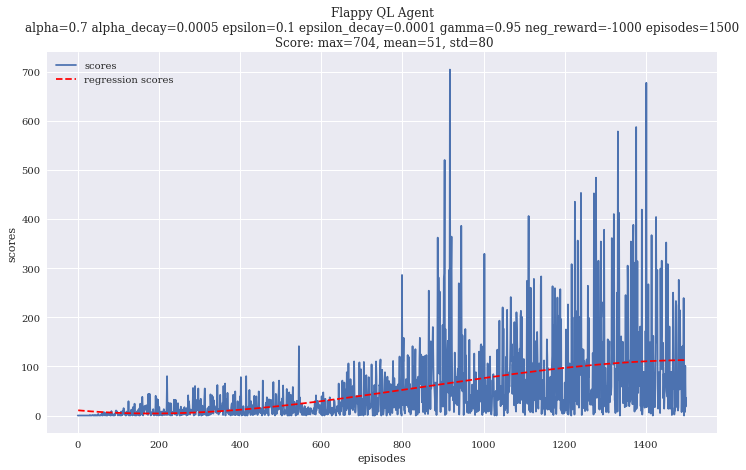

C:\Users\alban\AppData\Local\Temp\ipykernel_27720\4057855283.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf)


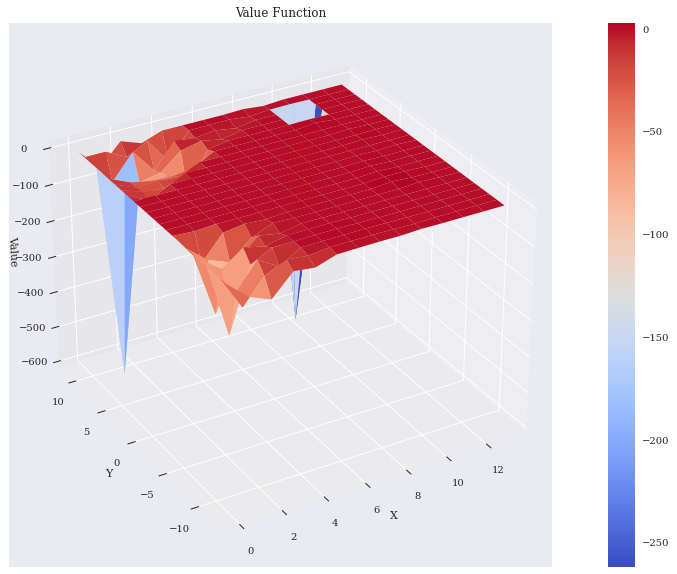

Time elapsed: 20 seconds


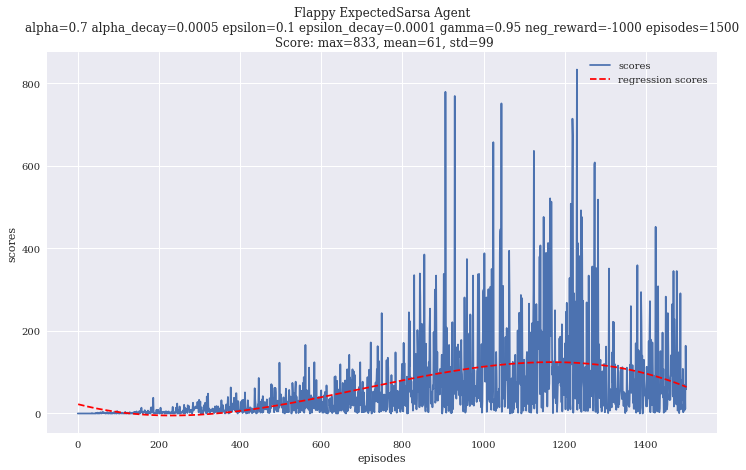

C:\Users\alban\AppData\Local\Temp\ipykernel_27720\4057855283.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf)


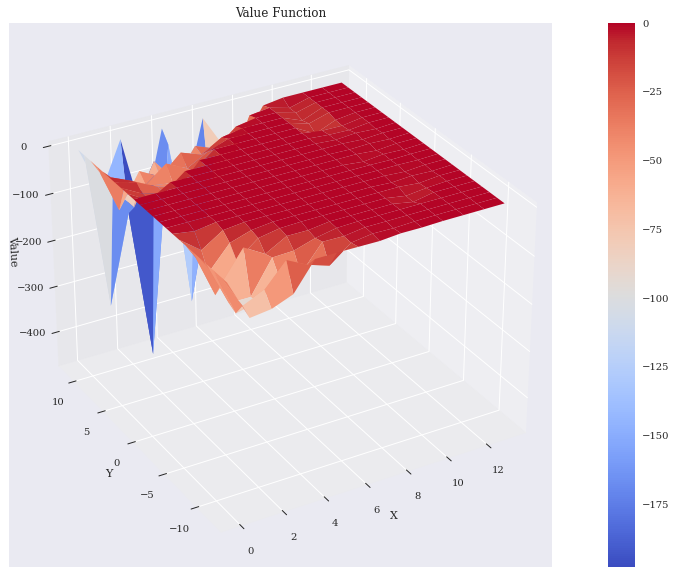

Time elapsed: 33 seconds


In [35]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
algos = ['QL', 'ExpectedSarsa']
for algo in algos:
    globals()[algo+'_agent'] = FlappyAgent(env, algo=algo)
    globals()[algo+'_agent'].learn()

In [36]:
def analysis_by_param(param: str, param_range: list):
    results = pd.DataFrame(index=param_range, columns=algos)
    for algo in algos:
        max_scores = []
        for value in param_range:
            agent = FlappyAgent(env, algo, plot=False)
            agent.__dict__[param] = value
            agent.learn()
            max_scores.append(agent.max_score)
        results[algo] = max_scores
    print(results.plot(title=agent.name.split('\n')[1].replace(f'{param}=', ''), ylabel='max score', xlabel=param))

AxesSubplot(0.125,0.125;0.775x0.755)


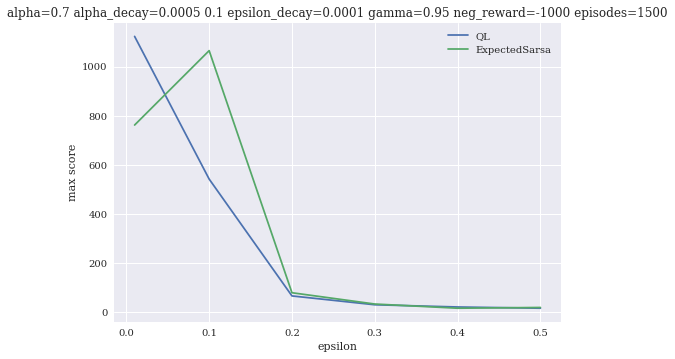

In [37]:
analysis_by_param('epsilon', [0.01, 0.1, 0.2, 0.3, 0.4 , 0.5])

AxesSubplot(0.125,0.125;0.775x0.755)


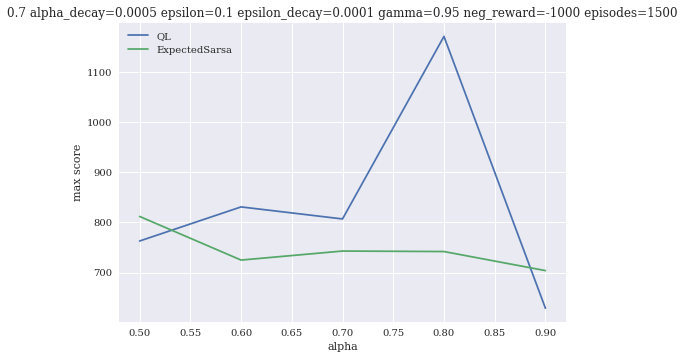

In [38]:
analysis_by_param('alpha', [0.5, 0.6, 0.7, 0.8, 0.9])

AxesSubplot(0.125,0.125;0.775x0.755)


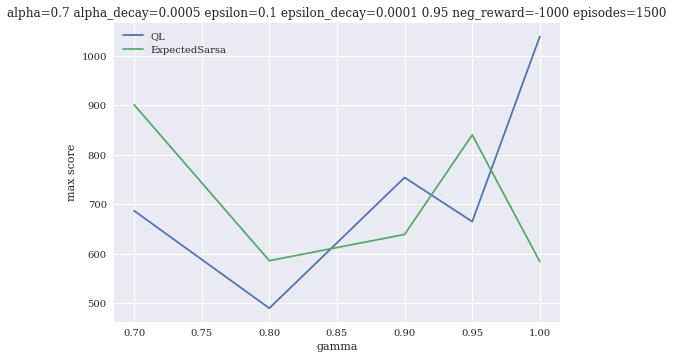

In [39]:
analysis_by_param('gamma', [0.7, 0.8, 0.9, 0.95, 1])

AxesSubplot(0.125,0.125;0.775x0.755)


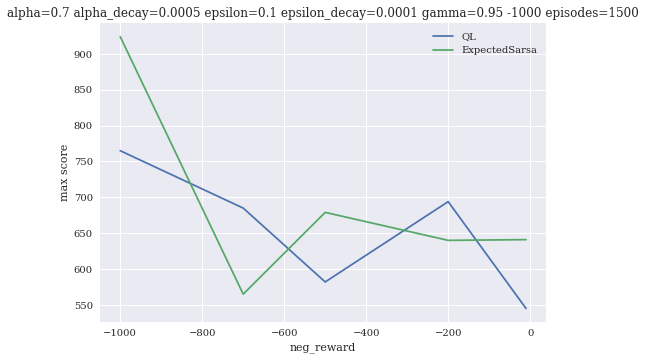

In [40]:
analysis_by_param('neg_reward', [-10, -200, -500, -700, -1000])

In [41]:
%pip install flappy_bird_gym

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
text-flappy-bird-gym 0.1.0 requires numpy==1.24.2, but you have numpy 1.19.5 which is incompatible.
gymnasium 0.27.1 requires numpy>=1.21.0, but you have numpy 1.19.5 which is incompatible.



  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl (13.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2


In [42]:
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")
ExpectedSarsa_agent.eval(env)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices